In [2]:
from tradeapp.tradeapp import TradingApp
import matplotlib.pyplot as plt
import time
import pandas
import numpy as np

In [319]:
app = TradingApp("9999", "0CEN4JP9")
#app.postOrder("BUY", "RITC", 1000)

In [425]:
app.getCaseDetails()

{'name': 'RITC 2023 Electricity Trading case - practice',
 'period': 2,
 'tick': 0,
 'ticks_per_period': 181,
 'total_periods': 5,
 'status': 'STOPPED',
 'is_enforce_trading_limits': True}

In [3]:
tendies = []
while True:
    tend = app.getTenders()
    if tend != None:
        tendies.append(tend)
        print(tend)
    time.sleep(5)

KeyboardInterrupt: 

In [4]:
tendies_dict = {list(tendies[i].keys())[0]: list(tendies[i].values())[0] for i in range(len(tendies))}
tendies_df = pandas.DataFrame(tendies_dict).transpose().set_index("tick")
tendies_df

KeyError: "None of ['tick'] are in the columns"

In [320]:
df_RITC_hist = app.getSecuritiesHistory("RITC").set_index("tick")[::-1]
df_BULL_hist = app.getSecuritiesHistory("BULL").set_index("tick")[::-1]
df_BEAR_hist = app.getSecuritiesHistory("BEAR").set_index("tick")[::-1]
df_USD_hist = app.getSecuritiesHistory("USD").set_index("tick")[::-1]
df = pandas.concat([df_RITC_hist.close, df_BULL_hist.close, df_BEAR_hist.close, df_USD_hist.close], axis=1)
df.columns = ["RITC", "BULL", "BEAR", "USD"]
df["RITC_undrlyng"] = df["BULL"] + df["BEAR"]
df["RITC"] = df["RITC"] * df["USD"]
commission = 0.12 # per share
slippage = 0.1 # per share
adj_commision = commission + slippage
f, axarr = plt.subplots(2, figsize=(20,10), sharex=True)
axarr[0].plot(df.index, df["RITC_undrlyng"], c="b", linewidth=1, label=r"RITC underlying $(BULL - BEAR)/USD$")
axarr[0].plot(df.index, df["RITC"], c="r", linewidth=2, label="RITC (USD adjusted)")
# for i in range(len(tendies_df)):
#     axarr[0].axvline(x=tendies_df.index[i], color='black', linewidth=0.5, linestyle='--')
#     axarr[0].axvline(x=tendies_df.iloc[i]["expires"], color='black', linewidth=0.5, linestyle='--')
#     axarr[0].axvspan(tendies_df.index[i], tendies_df.iloc[i]["expires"], alpha=0.1, color='green' if tendies_df.iloc[i]["action"] == "BUY" else "red")
#     axarr[0].scatter(tendies_df.index[i], tendies_df.iloc[i]["price"]*df.iloc[tendies_df.index[i]]["USD"], c="black", marker="x", s=100)

axarr[0].set_ylabel('Price in CAD')
axarr[0].grid()
axarr[0].legend()
axarr[0].set_title('RITC underlying vs RITC price timeseries')

axarr[1].plot(df.index, df["RITC_undrlyng"] - df["RITC"], c="black", label=r"RITC underlying - RITC")
axarr[1].annotate('LONG RITC', xy=(0, 0), xytext=(0, 0.25))
axarr[1].annotate('SHORT RITC', xy=(0, 0), xytext=(0, -0.25))
axarr[1].set_title('Price differential')
axarr[1].set_ylabel('Price difference in CAD')
axarr[1].fill_between(df.index, df["RITC_undrlyng"] - df["RITC"], adj_commision, where=df["RITC_undrlyng"] - df["RITC"] > adj_commision, facecolor='green', alpha=0.5, label="profit")
axarr[1].fill_between(df.index, df["RITC_undrlyng"] - df["RITC"], -adj_commision, where=df["RITC_undrlyng"] - df["RITC"] < -adj_commision, facecolor='green', alpha=0.5)
axarr[1].legend()
axarr[1].grid(axis='y')
axarr[1].axhline(y=0, color='black', linestyle='--')
axarr[1].set_xlabel('tick')


AssertionError: 

In [418]:
df_RITC_hist = app.getSecuritiesHistory("RTM").set_index("tick")[::-1]


AssertionError: 

In [76]:
import scipy.stats as ss

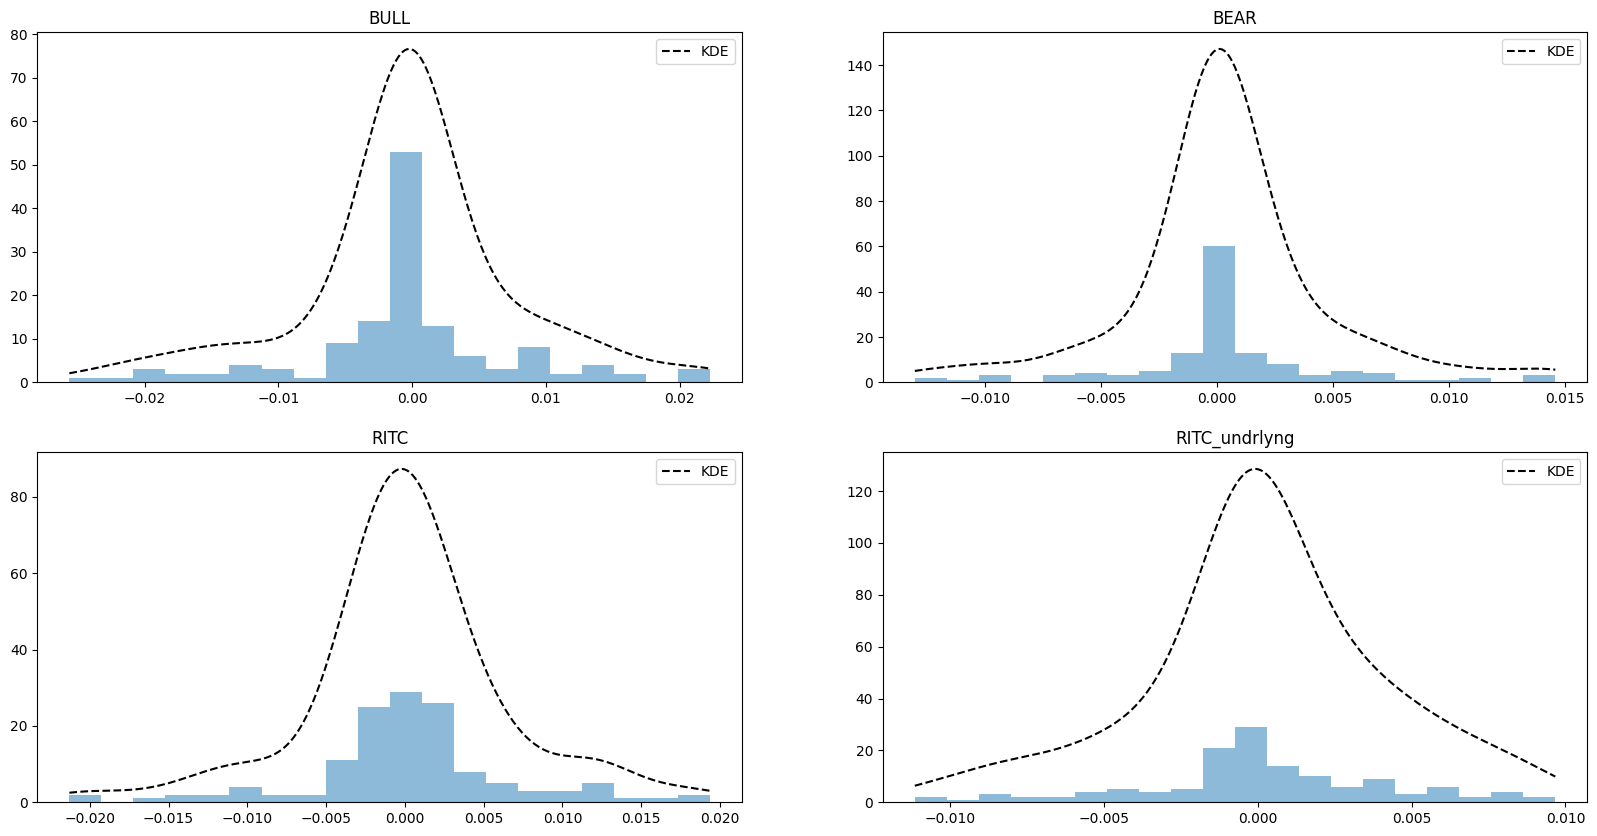

In [380]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))

pct_ch_df = df.pct_change().dropna()
pct_ch_df = pct_ch_df[["BULL", "BEAR", "RITC", "RITC_undrlyng"]]
# estimate Kernel Density and plot
for i in range(2):
    for j in range(2):
        axs[i,j].set_title(pct_ch_df.columns[i*2+j])
        axs[i,j].hist(pct_ch_df[pct_ch_df.columns[i*2+j]], alpha=0.5, bins=20)

        x = np.linspace(pct_ch_df[pct_ch_df.columns[i*2+j]].min(), pct_ch_df[pct_ch_df.columns[i*2+j]].max(), 301)
        kde = ss.gaussian_kde(pct_ch_df[pct_ch_df.columns[i*2+j]])
        axs[i,j].plot(x, kde.pdf(x), linestyle = "--", c="black", label='KDE')
        axs[i,j].legend()

In [315]:
securities = list(app.getSecurities().keys())
bidask = {sec: app.getSecuritiesBook(sec,6) for sec in securities}

In [316]:
for sec in securities:
    bidask[sec]["bids"]["ev_vwap"] = ((bidask[sec]["bids"]["price"] * bidask[sec]["bids"]["quantity"])/bidask[sec]["bids"]["quantity"]).expanding().mean()
    bidask[sec]["asks"]["ev_vwap"] = ((bidask[sec]["asks"]["price"] * bidask[sec]["asks"]["quantity"])/bidask[sec]["asks"]["quantity"]).expanding().mean()

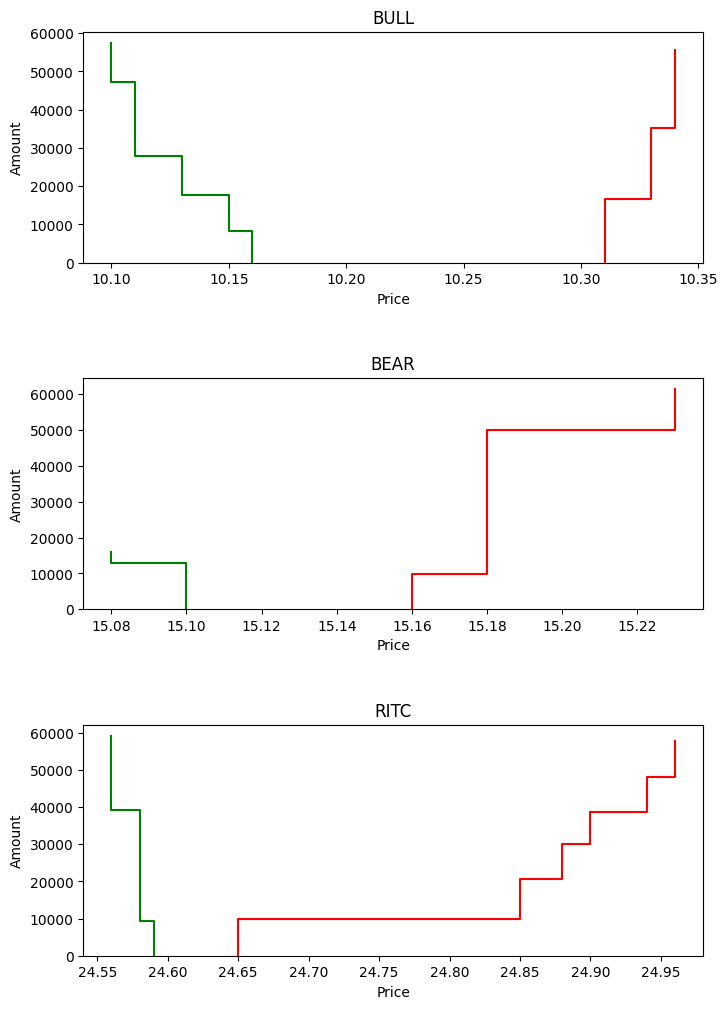

In [317]:
import seaborn as sns


fig, ax = plt.subplots(3, 1, figsize=(8, 12))
fig.subplots_adjust(hspace=0.5)

for i, val in enumerate(securities[2:]):
    # bid side
    sns.ecdfplot(x="price", weights="quantity", stat="count", complementary=True, data=bidask[val]["bids"], ax=ax[i], color='g')
    # ask side
    sns.ecdfplot(x="price", weights="quantity", stat="count", data=bidask[val]["asks"], ax=ax[i], color='r')
    ax[i].set_title(val)
    ax[i].set_xlabel("Price")
    ax[i].set_ylabel("Amount")

In [313]:
bidask_BEAR["bids"]

,period,tick,trader_id,ticker,quantity,price,type,action,quantity_filled,vwap,status
order_id,,,,,,,,,,,
2433,1,168,h1,BEAR,1000.0,16.74,LIMIT,BUY,0.0,NaN,OPEN
2394,1,166,ANON,BEAR,7300.0,16.73,LIMIT,BUY,3000.0,16.73,OPEN
2372,1,165,h1,BEAR,1000.0,16.70,LIMIT,BUY,0.0,NaN,OPEN
2359,1,164,ANON,BEAR,7200.0,16.69,LIMIT,BUY,0.0,NaN,OPEN
2382,1,165,ANON,BEAR,9100.0,16.69,LIMIT,BUY,0.0,NaN,OPEN
2347,1,163,h1,BEAR,100.0,16.68,LIMIT,BUY,0.0,NaN,OPEN
2334,1,162,h1,BEAR,1000.0,16.67,LIMIT,BUY,0.0,NaN,OPEN
2432,1,168,ANON,BEAR,9800.0,16.66,LIMIT,BUY,0.0,NaN,OPEN
2285,1,159,ANON,BEAR,8100.0,16.65,LIMIT,BUY,1600.0,16.65,OPEN


In [41]:
app.getTenders()

{3541: {'period': 1,
  'tick': 235,
  'expires': 241,
  'caption': 'An institution would like to BUY 71000 shares of RITC from you at a price of 24.26.  Would you like to SELL the shares to them?',
  'ticker': 'RITC',
  'quantity': 71000.0,
  'action': 'SELL',
  'is_fixed_bid': True,
  'price': 24.26}}

In [114]:
tend = app.getTenders()

In [115]:
tend

{541: {'period': 1,
  'tick': 47,
  'expires': 53,
  'caption': 'An institution would like to SELL 98000 shares of RITC to you at a price of 24.55.  Would you like to BUY the shares from them?',
  'ticker': 'RITC',
  'quantity': 98000.0,
  'action': 'BUY',
  'is_fixed_bid': True,
  'price': 24.55}}

,spread_in_pct,volatility
spread_in_pct,1.000000,0.739142
volatility,0.739142,1.000000


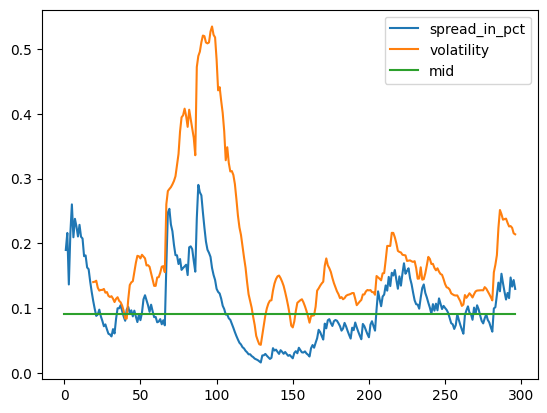

In [290]:
app = TradingApp("9999", "0CEN4JP9")
hist = app.getSecuritiesHistory("RITC")
hist["spread"] = hist["high"] - hist["low"]
hist["volatility"] = hist["close"].rolling(20).std()
#we divide by the midpoint to make te spread comparable
hist["spread_in_pct"] = (hist["spread"]).ewm(span=20).mean().shift(1)
hist["mid"] = hist["spread_in_pct"].median()
hist[["spread_in_pct", "volatility", "mid"]].plot()

hist[["spread_in_pct", "volatility"]].corr()

In [278]:
import sklearn.linear_model as lm

In [279]:
hist = hist.dropna()

In [280]:
model = lm.LinearRegression().fit(hist[["spread_in_pct", "volatility"]], hist["mid"])

In [283]:
model.coef_

array([0., 0.])

In [281]:
model.score(hist[["spread_in_pct", "volatility"]], hist["mid"])

1.0

In [282]:
import statsmodels.formula.api as smf
import statsmodels.api as sm 

hist["intercept"] = 1
reg = sm.OLS(hist["spread"], hist[["volatility"]]).fit()

reg.summary() 



C:\Users\Felix\AppData\Local\Temp\ipykernel_1016\3118591996.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist["intercept"] = 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 spread   R-squared (uncentered):                   0.333
Model:                            OLS   Adj. R-squared (uncentered):              0.326
Method:                 Least Squares   F-statistic:                              46.51
Date:                Thu, 23 Feb 2023   Prob (F-statistic):                    9.05e-10
Time:                        17:09:45   Log-Likelihood:                          76.873
No. Observations:                  94   AIC:                                     -151.7
Df Residuals:                      93   BIC:                                     -149.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
volatility     0.5121      0.075      6.820      0.000       0.363       0.661
==============================================================================
Omnibus:                       27.843   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.407
Skew:                           1.390   Prob(JB):                     1.68e-09
Kurtosis:                       4.609   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [209]:
app.getSecuritiesBook("RITC", df=True)["bids"]

,period,tick,trader_id,ticker,quantity,price,type,action,quantity_filled,vwap,status
order_id,,,,,,,,,,,
929,1,48,gwtr,RITC,5000.0,25.10,LIMIT,BUY,0.0,NaN,OPEN
141,1,0,ANON,RITC,11100.0,24.83,LIMIT,BUY,5400.0,24.83,OPEN
232,1,9,ANON,RITC,10500.0,24.80,LIMIT,BUY,0.0,NaN,OPEN
609,1,32,ANON,RITC,9000.0,24.80,LIMIT,BUY,0.0,NaN,OPEN
470,1,26,ANON,RITC,8300.0,24.74,LIMIT,BUY,0.0,NaN,OPEN
250,1,10,ANON,RITC,10400.0,24.71,LIMIT,BUY,0.0,NaN,OPEN
530,1,28,ANON,RITC,11600.0,24.71,LIMIT,BUY,0.0,NaN,OPEN
137,1,0,ANON,RITC,10100.0,24.67,LIMIT,BUY,0.0,NaN,OPEN
127,1,0,ANON,RITC,10800.0,24.66,LIMIT,BUY,0.0,NaN,OPEN


In [310]:
RITC_book = app.getSecuritiesBook("RITC", 10,df = False)
RITC_book = np.array([[int(RITC_book["asks"][i]["quantity"] - RITC_book["asks"][i]["quantity_filled"]), float(RITC_book["asks"][i]["price"])] for i in range(len(RITC_book["bids"]))])

In [311]:
RITC_book = RITC_book[::-1]
sum = RITC_book[:,0].sum()/(RITC_book[-1,1]-RITC_book[0,1])

In [312]:
sum/100

-1802.3809523809603

In [132]:
RITC_book = RITC_book[::-1]
if RITC_book[0,1] - RITC_book[1,1] > 0.05:
    qty_good = RITC_book[0,0]
    qty_second = RITC_book[1,0]
    l = (RITC_book[0,1]-RITC_book[1,1])/0.05
    qty_to

    app.postOrder("SELL", "RITC", 100, price = RITC_book[0,2]-0.01, order_type="LIMIT")

IndexError: index 2 is out of bounds for axis 1 with size 2

In [137]:
RITC_book[0]

array([2278.  ,   24.98])

In [322]:
app = TradingApp("9999", "0CEN4JP9")

app.getTenders()

{0: {'period': 1,
  'tick': 89,
  'expires': 105,
  'caption': 'Please provide a bid for 85000 shares of COMP. Anyone who bids higher than the reserve will get filled.',
  'ticker': 'COMP',
  'quantity': 85000.0,
  'action': 'BUY',
  'is_fixed_bid': False,
  'price': None}}